In [2]:
pip install opencv-python pillow numpy scikit-learn tensorflow torch torchvision


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\nilay agarwal\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [7]:
pip install scikit-image


You should consider upgrading via the 'C:\Users\nilay agarwal\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [8]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr


In [16]:
import os
import cv2

def load_images_from_directory(directory, image_size=(128, 128)):
    image_list = []
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    for file in files:
        path_to_image = os.path.join(directory, file)
        image = cv2.imread(path_to_image)
        if image is None:
            continue
        
        # Process the image
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(rgb_image, image_size)
        normalized_image = resized_image.astype('float32') / 255.0
        
        image_list.append(normalized_image)
    
    return image_list



In [17]:
noisy_directory = 'Downloads/low/low'
clean_directory = 'Downloads/high/high'
desired_image_size = (128, 128)  # Target image dimensions

noisy_image_data = load_images_from_directory(noisy_directory, desired_image_size)
clean_image_data = load_images_from_directory(clean_directory, desired_image_size)

In [18]:
train_noisy, test_noisy, train_clean, test_clean = train_test_split(
    noisy_images, clean_images, test_size=0.2, random_state=42
)


In [12]:

def preprocess_image(image):
    return tf.image.convert_image_dtype(image, tf.float32)

# Define batch size
batch_size = 32

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_noisy, train_clean)) \
                         .map(lambda x, y: (preprocess_image(x), preprocess_image(y))) \
                         .batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((test_noisy, test_clean)) \
                        .map(lambda x, y: (preprocess_image(x), preprocess_image(y))) \
                        .batch(batch_size)



In [19]:

def create_denoising_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return model

# Define input shape
input_shape = (128, 128, 3)

# Create the denoising model
model = create_denoising_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,731 (194.26 KB)

 Trainable params: 49,731 (194.26 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(train_ds, epochs=50, validation_data=test_ds)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 399ms/step - loss: 0.0471 - val_loss: 0.0395
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - loss: 0.0365 - val_loss: 0.0325
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - loss: 0.0324 - val_loss: 0.0296
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - loss: 0.0297 - val_loss: 0.0312
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 406ms/step - loss: 0.0308 - val_loss: 0.0281
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 416ms/step - loss: 0.0278 - val_loss: 0.0269
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - loss: 0.0274 - val_loss: 0.0267
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step - loss: 0.0267 - val_loss: 0.0262
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step - loss: 0.0266 - val_loss: 0.0260
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step - loss: 0.0265 - val_loss: 0.0257
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - loss: 0.0259 - val_loss: 0.0256
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step

In [21]:
predicted_images = model.predict(test_noisy_ds)

psnr_values = [psnr(test_clean[i], predicted_images[i]) for i in range(len(test_clean))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Average PSNR: 17.345213440237305


C:\Users\nilay agarwal\AppData\Local\Temp\ipykernel_31764\69829370.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_values = [psnr(test_clean[i], predicted_images[i]) for i in range(len(test_clean))]


In [24]:
#  We have displayed 5 images from training data and 5 images from our testing data

import matplotlib.pyplot as plt       
def plot_images(dataset, num_images=5):
    # Create an iterator for the dataset
    iterator = iter(dataset)
    
    # Get a batch of images and labels
    noisy_images, clean_images = next(iterator)
    
    # Plot the images
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        # Plot noisy image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(noisy_images[i])
        plt.title('Noisy Image')
        plt.axis('off')
        
        # Plot clean image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(clean_images[i])
        plt.title('Clean Image')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()



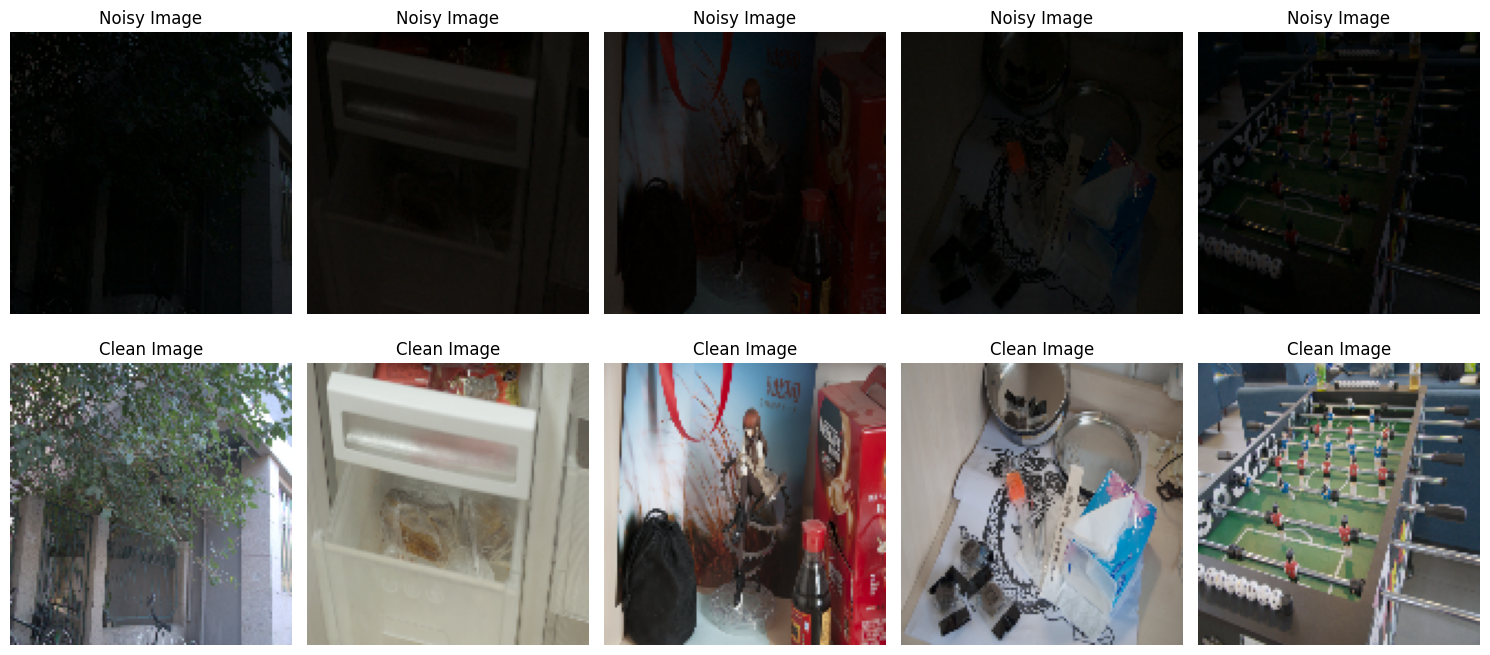

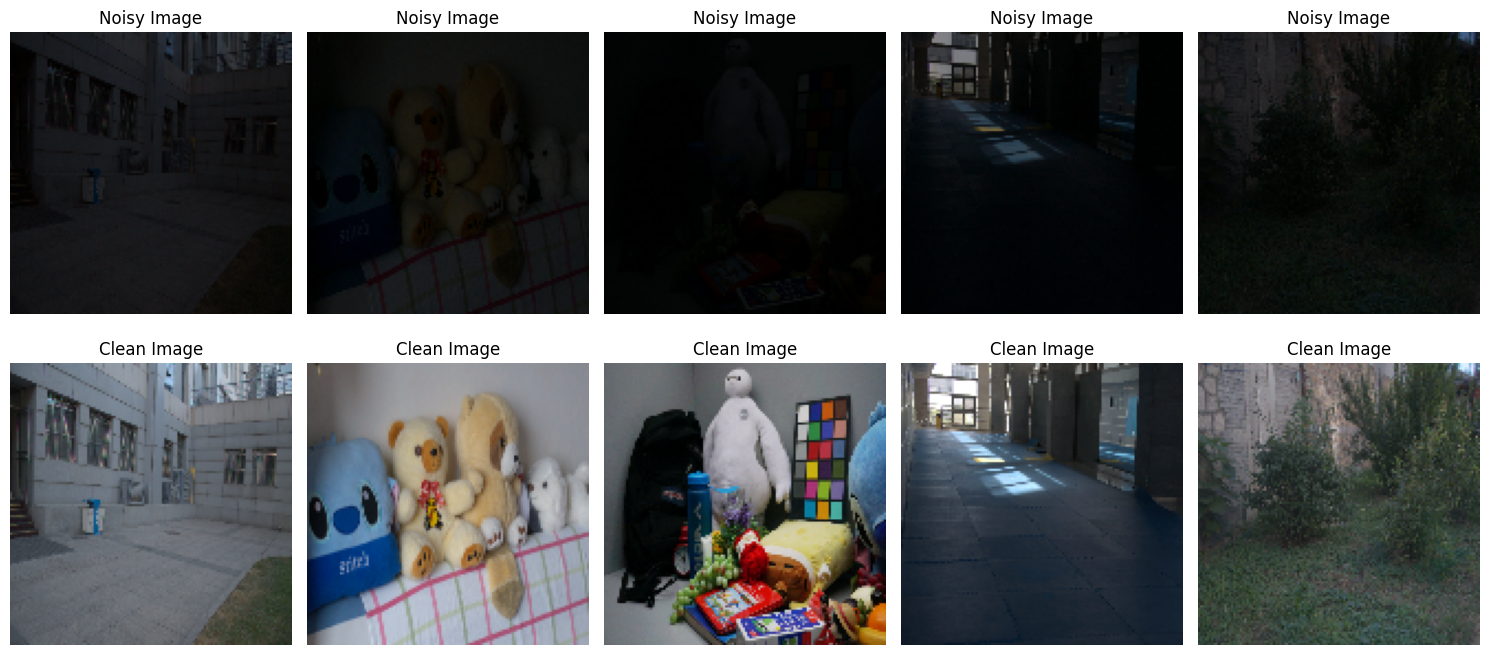

In [25]:
# Plot 5 images from the training dataset
plot_images(train_ds, num_images=5)

# Plot 5 images from the test dataset
plot_images(test_ds, num_images=5)
